# Bladder Cancer

## Data processing

In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

import shap
import lime
import json
from lime.lime_tabular import LimeTabularExplainer


# data load
df_BCa = pd.read_csv('BCa_raw.csv') # 암 원본 데이터 중 diagnosis 탭 data
df_BCa['Age'].fillna(df_BCa['Age'].mean(), inplace=True)


c:\Users\PC\anaconda3\envs\XAI_ML1\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\PC\anaconda3\envs\XAI_ML1\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

In [2]:
# 독립변수와 종속변수 정의

X_rf = df_BCa[['CK8','CK18','PD-1','PD-L1','Gender','Age']]

# diagnosis의 Y값 ('Decision')

Y = df_BCa['Decision']

# Column name의 list
col_name_rf = ['CK8','CK18','PD-1','PD-L1','Gender','Age']

# 독립변수(X) DataFrame 리스트
X_sets = [X_rf]

# 각 X 데이터셋의 이름
X_dataset_names = ['X_rf']

# 종속변수(y) Series 리스트
Y_sets = [Y]

# Col name 리스트
col_name_sets = [col_name_rf]

sets_name = ['rf']

num_sets = len(X_sets)

## Model.fit & predict

### 2) RandomForest

In [3]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier

# model.fit
rf= RandomForestClassifier()

# List에 4개의 rf model 담기
rf_classifiers = [rf]

In [4]:
from sklearn.model_selection import GridSearchCV

CV_rf = [None] * num_sets
for i in range(num_sets):
    # 데이터 분할
    X_train, X_test, Y_train, Y_test = train_test_split(X_sets[i], Y_sets[i], test_size=0.2, random_state=42)
    
    # GridSearchCV
    params_rf = { 
        'n_estimators': [100, 200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6],
    }

    # GridSearchCV 객체 생성 
    CV_rf[i] = GridSearchCV(estimator=rf_classifiers[i], param_grid=params_rf)

    # 모델 학습
    CV_rf[i].fit(X_train,Y_train)

    # 최적의 파라미터 출력 
    print(CV_rf[i].best_params_)
    
for i in range(num_sets):
    rf_classifiers[i].set_params(**CV_rf[i].best_params_)
    # rf_classifiers 리스트의 첫 번째 요소를 최적화된 모델로 교체


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

{'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}


- model.predict_proba

In [12]:
# 교차 검증(StratifiedKFold cross-validation) 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# results_proba_rf 딕셔너리 생성
results_rf = {}

# proba_result_rf
proba_rf = []

# Thresholds 설정 (0.1부터 0.7까지 0.05 간격으로 sweep)
thresholds = np.arange(0.1, 0.7, 0.05)

# ROC curve와 AUC 계산을 위한 빈 리스트 생성
roc_auc_list_rf = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]
fpr_list_rf = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]
tpr_list_rf = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]

best_threshold = 0.45


for i in range(num_sets):
    cm_total_rf = [0]*len(thresholds)
    acc_total_rf = [0]*len(thresholds)
    prec_total_rf = [0]*len(thresholds)
    rec_total_rf = [0]*len(thresholds)
    f1_total_rf = [0]*len(thresholds)
    auc_total_rf = [0]*len(thresholds)
    
    for num in range(len(thresholds)):
        cm_total_rf.append(np.zeros((2,2)))
        
    X_rf = X_sets[i].values
    Y_rf = Y_sets[i].values

    for j, (train_index, test_index) in enumerate(skf.split(X_rf, Y_rf)):
        X_train, X_test = X_rf[train_index], X_rf[test_index]
        Y_train, Y_test = Y_rf[train_index], Y_rf[test_index]

        rf_classifiers[i].fit(X_train, Y_train)
        predictions_proba=rf_classifiers[i].predict_proba(X_test)[:,1]
        fold_results = list(zip(test_index,predictions_proba))
        proba_rf.append(fold_results)
        predictions_xai = (predictions_proba > best_threshold).astype(int)
        
        # 예측과 실제값이 다른 index 추출
        misclassified_indices = np.where(predictions_xai != Y_test)[0]
        misclassified_indices_test = test_index[predictions_xai != Y_test]
        print('잘못 예측한 index 번호 list',misclassified_indices_test)
        
        for index, index_test in zip(misclassified_indices, misclassified_indices_test):
            if i==0:
                print(f"SHAP Force Plot for misclassified data point {index_test} in set {i+1}:")
                print('index #',index_test,'의 실제 정답은',Y_sets[0][index_test],'예측 결과는',predictions_proba[index])
                # SHAP force plot 그리기
                explainer_rf = shap.TreeExplainer(rf_classifiers[0])
                shap_values_rf = explainer_rf.shap_values(X_sets[0].values)
                shap.initjs()
                # plt.figure()
                # Save SHAP force plot as an image file
                shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][index_test], X_sets[0].iloc[index_test], show=False,matplotlib=True).savefig(f"rf_shap_plots/SHAP Force Plot for misclassified data point {index_test}.png")
                plt.close()

                # LIME table 그리기
                lime_explainer_1_rf = LimeTabularExplainer(X_sets[0].to_numpy(), feature_names=X_sets[0].columns.tolist(), class_names=['Not Decision', 'Decision'], verbose=True)
                lime_exp_1_rf = lime_explainer_1_rf.explain_instance(X_sets[0].iloc[index_test], rf_classifiers[0].predict_proba)
                # lime_exp_1_rf.show_in_notebook()
                # Save LIME table as an image file
                lime_exp_1_rf.save_to_file(f"rf_lime_plots/LIME table for misclassified data point {index_test}.html")
        
        
            
        for idx, threshold in enumerate(thresholds):
            predictions=(predictions_proba>threshold).astype(int)   # 확률을 이진 레이블로 변환
            # roc_curve 함수로 FPR (False Positive Rate)과 TPR (True Positive Rate) 계산
            fpr, tpr, thre = roc_curve(Y_test.astype(int), predictions_proba)
            # AUC 계산
            roc_auc = roc_auc_score(Y_test.astype(int), predictions_proba)
            fpr_list_rf[i][j] = fpr
            tpr_list_rf[i][j] = tpr
            roc_auc_list_rf[i][j][idx] = roc_auc
            cm_total_rf[idx]+=confusion_matrix(Y_test.astype(int),predictions)
            acc_total_rf[idx]+=accuracy_score(Y_test.astype(int),predictions)
            prec_total_rf[idx]+=precision_score(Y_test.astype(int),predictions)
            rec_total_rf[idx]+=recall_score(Y_test.astype(int),predictions)
            f1_total_rf[idx]+=f1_score(Y_test.astype(int), predictions)
            auc_total_rf[idx]+=roc_auc_score(Y_test.astype(int), predictions_proba)


            if f"Model {i+1}" not in results_rf:
                results_rf[f"Model {i+1}"]={}
                
            results_rf[f"Model {i+1}"][threshold]={
                "Confusion Matrix": cm_total_rf[idx],
                "Accuracy": acc_total_rf[idx] / skf.get_n_splits(),
                "Precision": prec_total_rf[idx] / skf.get_n_splits(),
                "Recall": rec_total_rf[idx] / skf.get_n_splits(),
                
                "F1-Score": f1_total_rf[idx] / skf.get_n_splits(),
                "AUC": auc_total_rf[idx] / skf.get_n_splits()
            }
        
            

# Predict_proba값 index 순서대로 정렬 후 저장          
sorted_result_rf = [0]
df_proba_rf = [0]
proba_rf = np.concatenate(proba_rf)
sorted_result_rf = proba_rf[proba_rf[:, 0].argsort()]
df_proba_rf = pd.DataFrame(sorted_result_rf[:,1], columns=['Predictor value'])
    
# csv로 저장
df_proba_rf.to_csv('Predictor value rf.csv', index=False)

잘못 예측한 index 번호 list [46 62 71 80 82]
SHAP Force Plot for misclassified data point 46 in set 1:
index # 46 의 실제 정답은 1 예측 결과는 0.339371913952061


Intercept 0.67745506119437
Prediction_local [0.41707913]
Right: 0.339371913952061
SHAP Force Plot for misclassified data point 62 in set 1:
index # 62 의 실제 정답은 0 예측 결과는 0.5882740317565982


Intercept 0.6135224643130157
Prediction_local [0.59268379]
Right: 0.5882740317565982
SHAP Force Plot for misclassified data point 71 in set 1:
index # 71 의 실제 정답은 0 예측 결과는 0.5401642390289451


Intercept 0.6239922462685161
Prediction_local [0.74511845]
Right: 0.5401642390289451
SHAP Force Plot for misclassified data point 80 in set 1:
index # 80 의 실제 정답은 0 예측 결과는 0.6762174985145575


Intercept 0.6204705364636851
Prediction_local [0.73880437]
Right: 0.6762174985145575
SHAP Force Plot for misclassified data point 82 in set 1:
index # 82 의 실제 정답은 0 예측 결과는 0.7091106317063561


Intercept 0.623636890675459
Prediction_local [0.51186866]
Right: 0.7091106317063561
잘못 예측한 index 번호 list [24 69 72]
SHAP Force Plot for misclassified data point 24 in set 1:
index # 24 의 실제 정답은 1 예측 결과는 0.42910215884210745


Intercept 0.7435595445097216
Prediction_local [0.25364226]
Right: 0.42910215884210745
SHAP Force Plot for misclassified data point 69 in set 1:
index # 69 의 실제 정답은 0 예측 결과는 0.4783442623325815


Intercept 0.5744840990531638
Prediction_local [0.48931974]
Right: 0.4783442623325815
SHAP Force Plot for misclassified data point 72 in set 1:
index # 72 의 실제 정답은 0 예측 결과는 0.947246384820853


Intercept 0.47976726675496206
Prediction_local [0.78321233]
Right: 0.947246384820853
잘못 예측한 index 번호 list [ 1  8 56]
SHAP Force Plot for misclassified data point 1 in set 1:
index # 1 의 실제 정답은 1 예측 결과는 0.3751459491503588


Intercept 0.693055634997942
Prediction_local [0.40362903]
Right: 0.3751459491503588
SHAP Force Plot for misclassified data point 8 in set 1:
index # 8 의 실제 정답은 1 예측 결과는 0.28256863910628577


Intercept 0.7642088351398508
Prediction_local [0.32797603]
Right: 0.28256863910628577
SHAP Force Plot for misclassified data point 56 in set 1:
index # 56 의 실제 정답은 0 예측 결과는 0.837813061938062


Intercept 0.6686990353816302
Prediction_local [0.61663524]
Right: 0.837813061938062
잘못 예측한 index 번호 list [57 70]
SHAP Force Plot for misclassified data point 57 in set 1:
index # 57 의 실제 정답은 0 예측 결과는 0.5252387751675642


Intercept 0.7282868691879028
Prediction_local [0.45306996]
Right: 0.5252387751675642
SHAP Force Plot for misclassified data point 70 in set 1:
index # 70 의 실제 정답은 0 예측 결과는 0.5134721378761827


Intercept 0.6473171300619586
Prediction_local [0.53958385]
Right: 0.5134721378761827
잘못 예측한 index 번호 list [48 51]
SHAP Force Plot for misclassified data point 48 in set 1:
index # 48 의 실제 정답은 1 예측 결과는 0.26303886933454423


Intercept 0.777021077596484
Prediction_local [0.25728665]
Right: 0.26303886933454423
SHAP Force Plot for misclassified data point 51 in set 1:
index # 51 의 실제 정답은 1 예측 결과는 0.4385767967126327


Intercept 0.6831054995888115
Prediction_local [0.56962258]
Right: 0.4385767967126327


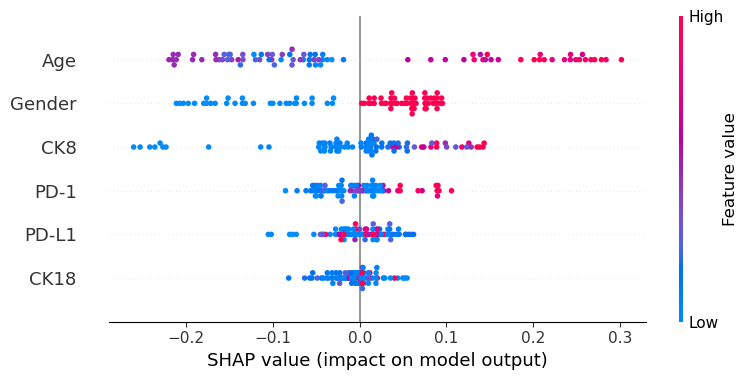

In [16]:
for i in range(num_sets):
    explainer_summary_rf = shap.TreeExplainer(rf_classifiers[i])
    shap_values_summary_rf = explainer_summary_rf.shap_values(X_sets[i].values,Y_sets[i].values)
    shap.summary_plot(shap_values_summary_rf[1], X_sets[i])

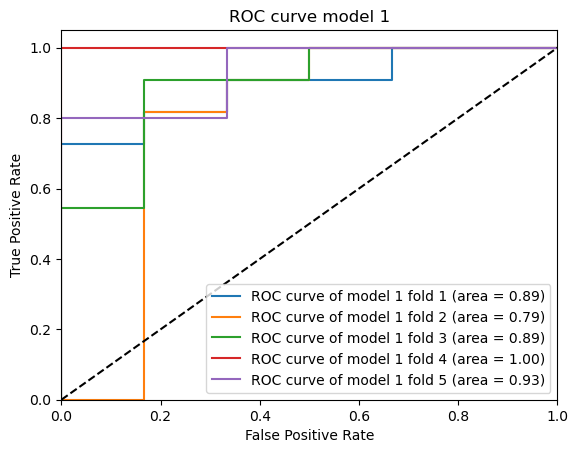

In [ ]:
from sklearn.metrics import roc_curve, auc

i = 0  # 첫번째 모델 선택

# Fold 별로 반복
for j in range(skf.get_n_splits()):

    # 실제 레이블과 예측 확률을 기반으로 FPR, TPR 계산
    fpr = np.array(fpr_list_rf[i][j]).flatten()
    tpr = np.array(tpr_list_rf[i][j]).flatten()
    
    # AUC 계산
    roc_auc = auc(fpr, tpr)

    # ROC curve 그리기
    plt.plot(fpr, tpr, label=f'ROC curve of model {i+1} fold {j+1} (area = {roc_auc:0.2f})')
# 대각선 추가 (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve model 1')
plt.legend(loc="lower right")

# Plot 표시
plt.show()

In [ ]:
# 데이터프레임 생성을 위한 빈 리스트 초기화
data_metrics_rf = []

# results_byth_rf 딕셔너리의 내용을 데이터프레임에 추가
for model, thresholds in results_rf.items():
    for threshold in thresholds:
        if threshold in thresholds:
            metrics = thresholds[threshold]
            accuracy = metrics['Accuracy']
            precision = metrics['Precision']
            recall = metrics['Recall']
            f1_score = metrics['F1-Score']
            auc = metrics['AUC']
        else:
            accuracy = None
            precision = None
            recall = None
            f1_score = None
            auc = None
            
        data_metrics_rf.append([model, threshold, accuracy, precision, recall, f1_score, auc])

# 데이터프레임 생성
df_metrics_rf = pd.DataFrame(data_metrics_rf, columns=['Model', 'Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score','AUC'])

df_metrics_rf

Model  Threshold  Accuracy  Precision    Recall  F1-Score       AUC
0   Model 1       0.10  0.675735   0.667081  1.000000  0.799188  0.901818
1   Model 1       0.15  0.711765   0.692670  1.000000  0.817430  0.901818
2   Model 1       0.20  0.760294   0.730437  1.000000  0.843430  0.901818
3   Model 1       0.25  0.748529   0.757739  0.923636  0.826144  0.901818
4   Model 1       0.30  0.795588   0.804788  0.923636  0.853782  0.901818
5   Model 1       0.35  0.831618   0.846653  0.923636  0.876176  0.901818
6   Model 1       0.40  0.831618   0.846653  0.923636  0.876176  0.901818
7   Model 1       0.45  0.843382   0.868998  0.905455  0.881335  0.901818
8   Model 1       0.50  0.795588   0.875260  0.812727  0.833684  0.901818
9   Model 1       0.55  0.784559   0.898232  0.756364  0.811481  0.901818
10  Model 1       0.60  0.772794   0.894661  0.738182  0.797446  0.901818
11  Model 1       0.65  0.749265   0.883232  0.701818  0.764113  0.901818

In [ ]:
# 각 set 별 threshold 별 confusion matrix 출력
for i in range(num_sets):
    for idx, threshold in enumerate(thresholds):
        # Confusion Matrix 출력
        print(f"Set {sets_name[i]}, Threshold: {threshold}")
        print(results_rf[f"Model {i+1}"][threshold]["Confusion Matrix"])
        print()

# false negative들을 dictionary에 담기
false_negatives_rf = {}
for i in range(num_sets):
    for threshold in thresholds:
        if f"Model {i+1}" not in false_negatives_rf:
            false_negatives_rf[f"Model {i+1}"] = {}
        
        # False Negatives Rate 계산 및 저장
        cm = results_rf[f"Model {i+1}"][threshold]["Confusion Matrix"]
        false_negatives_rate = cm[1][0] / (cm[1][0] + cm[1][1])
        
        # False Negatives Rate를 dictionary에 저장
        false_negatives_rate_dict = {"False Negatives Rate": false_negatives_rate}
        false_negatives_rf[f"Model {i+1}"][threshold] = false_negatives_rate_dict

# 결과 확인하기
print(false_negatives_rf)


Set cb, Threshold: 0.1
[[ 3 27]
 [ 0 53]]

Set cb, Threshold: 0.15000000000000002
[[ 6 24]
 [ 0 53]]

Set cb, Threshold: 0.20000000000000004
[[10 20]
 [ 0 53]]

Set cb, Threshold: 0.25000000000000006
[[13 17]
 [ 4 49]]

Set cb, Threshold: 0.30000000000000004
[[17 13]
 [ 4 49]]

Set cb, Threshold: 0.3500000000000001
[[20 10]
 [ 4 49]]

Set cb, Threshold: 0.40000000000000013
[[20 10]
 [ 4 49]]

Set cb, Threshold: 0.45000000000000007
[[22  8]
 [ 5 48]]

Set cb, Threshold: 0.5000000000000001
[[23  7]
 [10 43]]

Set cb, Threshold: 0.5500000000000002
[[25  5]
 [13 40]]

Set cb, Threshold: 0.6000000000000002
[[25  5]
 [14 39]]

Set cb, Threshold: 0.6500000000000001
[[25  5]
 [16 37]]

{'Model 1': {0.1: {'False Negatives Rate': 0.0}, 0.15000000000000002: {'False Negatives Rate': 0.0}, 0.20000000000000004: {'False Negatives Rate': 0.0}, 0.25000000000000006: {'False Negatives Rate': 0.07547169811320754}, 0.30000000000000004: {'False Negatives Rate': 0.07547169811320754}, 0.3500000000000001: {'Fa

In [ ]:
# 데이터프레임 생성을 위한 빈 리스트 초기화
data_falsenegative_rf = []

# false_negatives_rf 딕셔너리의 내용을 데이터프레임에 추가
for model, thresholds in false_negatives_rf.items():
    for threshold, metrics in thresholds.items():
        false_neg_rate = metrics['False Negatives Rate']
        data_falsenegative_rf.append([model, threshold, false_neg_rate])

# 데이터프레임 생성
df_false_negatives_rf = pd.DataFrame(data_falsenegative_rf, columns=['Model', 'Threshold', 'False Negatives Rate'])

# 출력
df_false_negatives_rf

Model  Threshold  False Negatives Rate
0   Model 1       0.10              0.000000
1   Model 1       0.15              0.000000
2   Model 1       0.20              0.000000
3   Model 1       0.25              0.075472
4   Model 1       0.30              0.075472
5   Model 1       0.35              0.075472
6   Model 1       0.40              0.075472
7   Model 1       0.45              0.094340
8   Model 1       0.50              0.188679
9   Model 1       0.55              0.245283
10  Model 1       0.60              0.264151
11  Model 1       0.65              0.301887

In [ ]:
# df_false_negatives와 df_byth_rf 합치기 (outer join)
df_combined_rf = pd.merge(df_false_negatives_rf, df_metrics_rf, on=["Model", "Threshold"],how="outer")

# 출력
df_combined_rf


Model  Threshold  False Negatives Rate  Accuracy  Precision    Recall  \
0   Model 1       0.10              0.000000  0.675735   0.667081  1.000000   
1   Model 1       0.15              0.000000  0.711765   0.692670  1.000000   
2   Model 1       0.20              0.000000  0.760294   0.730437  1.000000   
3   Model 1       0.25              0.075472  0.748529   0.757739  0.923636   
4   Model 1       0.30              0.075472  0.795588   0.804788  0.923636   
5   Model 1       0.35              0.075472  0.831618   0.846653  0.923636   
6   Model 1       0.40              0.075472  0.831618   0.846653  0.923636   
7   Model 1       0.45              0.094340  0.843382   0.868998  0.905455   
8   Model 1       0.50              0.188679  0.795588   0.875260  0.812727   
9   Model 1       0.55              0.245283  0.784559   0.898232  0.756364   
10  Model 1       0.60              0.264151  0.772794   0.894661  0.738182   
11  Model 1       0.65              0.301887  0.749265   0.883232  0.701818   

    F1-Score       AUC  
0   0.799188  0.901818  
1   0.817430  0.901818  
2   0.843430  0.901818  
3   0.826144  0.901818  
4   0.853782  0.901818  
5   0.876176  0.901818  
6   0.876176  0.901818  
7   0.881335  0.901818  
8   0.833684  0.901818  
9   0.811481  0.901818  
10  0.797446  0.901818  
11  0.764113  0.901818

In [ ]:
# CSV 파일로 저장
df_combined_rf.to_csv('df_combined_rf.csv', index=False)
